# main.ipynb

\<< Short description >>

Authors: Angelo D. Bonzanini, Giorgos Makrygiorgos, and Victor Miller \\
(c) January 2021

## Requirements:
* Add any particular modules that need to be installed
* Add any files that need to be in the same folder (e.g., ResNet.ipynb)
* Python version
* etc.

\<< Write some basic documentation here >>

## Setting up the environment and importing modules

* First, we import standard libraries such as matplotlib, numpy, etc. If a library (e.g., casadi) is not installed create a new cell and type:
```
!pip install casadi
```

* Because .ipynb files arenot .py files, we cannot readily import them as we would a .py file. Forunately, we can use the [import_ipynb](https://pypi.org/project/import-ipynb/) module to import .ipynb files. We just need to make sure that we change the directory to wherever the .ipynb file is located.

* Note: if you are using Google colab, we need to make sure that we are installing the libraries on our Google drive folder. Otherwise, next time we open the notebook we will have to re-install the libraries. To circumvent this issue, we we first need to give access to the colab notebook to read the Google Drive (using ```drive.mount()```) and then use pip with a target, i.e.,
```
!pip install --target=$path casadi
```


In [1]:
# Import libraries
import os, sys
import matplotlib.pyplot as plt
from casadi import *
import import_ipynb

In [2]:
# Import other Python notebooks
from ResNetExplicit import *

importing Jupyter notebook from ResNetExplicit.ipynb
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            40          input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            72          dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 8)            72          dense_1[0][0]                    
_________________________________________

Epoch 58/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0120
Epoch 59/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0137 - val_loss: 0.0123
Epoch 60/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 61/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0135 - val_loss: 0.0117
Epoch 62/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 63/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0126 - val_loss: 0.0136
Epoch 64/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 65/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0111
Epoch 66/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 67/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0127

Epoch 138/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 139/300
168/168 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0041
Epoch 140/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 141/300
168/168 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0067
Epoch 142/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0028
Epoch 143/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 144/300
168/168 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 145/300
168/168 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 146/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 147/300
168/168 [==============================] - 0s 2ms/step - lo

168/168 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 218/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 219/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 220/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 221/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 222/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 223/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 224/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 225/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 226/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0034 - v

168/168 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0039
Epoch 297/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 298/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 299/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 300/300
168/168 [==============================] - 0s 2ms/step - loss: 0.0026 - val_loss: 0.0019
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 8)            40          input_1[0][0]          

ResNetExplicit.ipynb:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  {"nbformat":4,"nbformat_minor":0,"metadata":{"kernelspec":{"display_name":"Python 3","language":"python","name":"python3"},"language_info":{"codemirror_mode":{"name":"ipython","version":3},"file_extension":".py","mimetype":"text/x-python","name":"python","nbconvert_exporter":"python","pygments_lexer":"ipython3","version":"3.7.9"},"colab":{"name":"ResNetExplicit.ipynb","provenance":[]}},"cells":[{"cell_type":"code","metadata":{"id":"En7X94oQ4iBb","executionInfo":{"status":"ok","timestamp":1610452279661,"user_tz":-120,"elapsed":720,"user":{"displayName":"Mr. Angelo Domenico Bonzanini","photoUrl":"https://lh3.googleusercontent.com/a-/AOh14GhWH1B1T3nUSLxWoArNWr2xXEYeTimjC_-o3qgU-1i1I7WVyEUPiJJed-orv8G0ZG

[[ 0.21358418 14.413176    0.05050828]]
Xkplusone from residual net: [[ 0.21358418 14.413176    0.05050828]]
10.0 15.0 0.2 0.0
Xkplusone from plant: (0.22946368421052632, 13.809845065789474, 0.16285026315789472)


## Define a class that intializes all of the parameters and instantiate object

In [29]:
# Note that classes are conventionally defined with a capital first letter
class Parameters:
    # The __init__() function is like a constructor 
    #(can give it arguments if we want to intialize some parameters depending on how we instantiate the class)
    def __init__(self): 

        # Constants (conventionally with all-capitals)
        self.VIN = 1
        self.TSAMP = 0.005

        # Neural Net parameters
        self.n_hidden_layers = 5 
        self.n_nodes = 8
        # self.weights
        # self.biases

        # Horizon lengths
        self.Np =  10     # Prediction horizon
        self.Nsim = 100   # Simulation horizon
        self.Nmc = 1      # Monte Carlo simulations (maybe we won't need this)

        # Cost matrices and variable sizes
        self.nx = 3
        self.nu = 1
        # If we had a tracking objective, we would define Q and R here, too 

        # Variable bounds (as a list, not a numpy array)
        self.xMin = [0]*self.nx
        self.xMax = [999]*self.nx
        self.uMin = [5]*self.nu
        self.uMax = [15]*self.nu

        # Initial state (as a list, not a numpy array)
        self.xInit = [0.2, 15, 0]

p = Parameters()

## Modify any functions that need to take CasADi variables as inputs

Here, we redefine the ```eulerPlantNext(z)``` and ```predictive_model_resnet(z, W)``` functions.


In [30]:
def eulerPlantNext(z):
    #next states for plant
    #Define constants
    F = z[0]
    Cx = z[1]
    Ca = z[2]
    Cp = z[3]
    # print(F,Ca,Cx,Cp)
    Tsamp=0.005;
    mumax =40
    Ks =2e-1
    Yx =0.04
    Yp =0.8
    pstar=1.8
    Ca0=10.0

    kd= 1e-2;
    aa = 5.5;
    bb = 8e-1;

    # if Cp>pstar:
    #    mu = 0
    # else:
    #    mu = mumax*(Ca/(Ca+Ks))*(1-Cp/pstar)**3

    # Substitute if statement with step function
    # preMult = 1-heaviside(Cp-pstar)
    mu = mumax*(Ca/(Ca+Ks))*(1-Cp/pstar)**3

    #Rate Definitions
    fcx=(mu-kd)*Cx - F*Cx
    fcp=aa*fcx +bb*Cx- F*Cp
    fca=-(1/Yx)*fcx - (1/Yp)*fcp + F*(Ca0-Ca)

    Cx_kplusone = Cx + Tsamp*fcx
    Ca_kplusone = Ca + Tsamp*fca
    Cp_kplusone = Cp + Tsamp*fcp


    return Cx_kplusone, Ca_kplusone, Cp_kplusone



def resNetModel(zk,Wmat, Parameters): 
    #Assuming you can pass extra arguments to the function for casadi, otherwsise
    #Number of hidden layers and nodes are given once when we get the optimal resnet
    #The Bayesian Optimization Loop will be changing 
    n_hidden_layers = Parameters.n_hidden_layers
    n_nodes = Parameters.n_nodes
    model_input = reshape(zk,1,Parameters.nu+Parameters.nx)
    Wmat_nRows = Wmat.shape[0]
    
    #Initialize from input 
    sum0 = mtimes(model_input,Wmat[0]).T #Matrix multiplication weights*inputs
    sumbias0 = sum0 + Wmat[1] #Add bias to construct y = sum(wi*xi) + b
    #neuron_out = swish_eval(sum1bias)
    neuron_out = sumbias0/(1+exp(-sumbias0)) #explicitly writing swish activation, out = fact(y)

    #Forward prediction in hidden layers
    for k in range(n_hidden_layers-1):
        sum0 = mtimes(neuron_out.T,Wmat[2*k+2]).T
        sumbias0 = sum0 + Wmat[2*k+3]
        neuron_out = sumbias0/(1+exp(-sumbias0)) #explicitly writing swish activation

    #Final output layer with linear activation
    sum0 = mtimes(neuron_out.T,Wmat[Wmat_nRows-2]).T
    sumbias0 = sum0 + Wmat[Wmat_nRows-1]
    neuron_out = sumbias0  #linear activation

    return model_input[0,Parameters.nu:] + neuron_out.T


In [31]:
uk=np.array([10.0]) #Control Input
xk=np.array([0.2,15,0]) #Current States
zk=np.concatenate((uk,xk)).reshape(1,4) #
print(zk)

xkplusone_neural = DropModel.predict(zk.reshape(1,4))
print(xkplusone_neural)
zkplusone = resNetModel(DM(zk),Wmat, p)
print(zkplusone)

[[10.   0.2 15.   0. ]]
[[ 0.21358418 14.413176    0.05050828]]
[[0.213584, 14.4132, 0.0505083]]


ATTEMPT to embed DropModel into a CasADi function
(Still in experimental stage)

In [32]:
'''
nd=4
class dropModelCasadi(Callback):
  def __init__(self, name,  opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 1
  def get_n_out(self): return 1
  
  def get_sparsity_in(self,i):
      return Sparsity.dense(1,len(zk))

  def get_sparsity_out(self,i):
      return Sparsity.dense(1,len(xk))

  # Evaluate numerically
  def eval(self, arg):
    out = DropModel.predict(np.array(arg[0]))
    return [out]


dropModelFn = dropModelCasadi('dropModelCasadi', {"enable_fd":True})

zz = MX.sym('zz', 1, 4)
print(zk)
xNNvar = dropModelFn(zz)
xNN2 = dropModelFn(zk.reshape(1,4))
print(xNN2)
print(xkplusone_neural) 
'''

'\nnd=4\nclass dropModelCasadi(Callback):\n  def __init__(self, name,  opts={}):\n    Callback.__init__(self)\n    self.construct(name, opts)\n\n  # Number of inputs and outputs\n  def get_n_in(self): return 1\n  def get_n_out(self): return 1\n  \n  def get_sparsity_in(self,i):\n      return Sparsity.dense(1,len(zk))\n\n  def get_sparsity_out(self,i):\n      return Sparsity.dense(1,len(xk))\n\n  # Evaluate numerically\n  def eval(self, arg):\n    out = DropModel.predict(np.array(arg[0]))\n    return [out]\n\n\ndropModelFn = dropModelCasadi(\'dropModelCasadi\', {"enable_fd":True})\n\nzz = MX.sym(\'zz\', 1, 4)\nprint(zk)\nxNNvar = dropModelFn(zz)\nxNN2 = dropModelFn(zk.reshape(1,4))\nprint(xNN2)\nprint(xkplusone_neural) \n'

## Define variables, constraints, and functions

Use classes to organize the code

In [33]:
class CasadiVars:
    def __init__(self, p):
        self.x = MX.sym("x", p.nx)
        self.u = MX.sym("u", p.nu)


class CasadiFunctions:
    def __init__(self, p, vars):
        # xNext = eulerPlantNext(vertcat(vars.u, vars.x))
        xNext = resNetModel(vertcat(vars.u, vars.x).T, Wmat, p).T
        Lstage = -p.VIN*vars.x[0]*vars.u[0]*p.TSAMP
        self.dynamics = Function('dynamics', [vars.u, vars.x], [xNext], ['u', 'x'], ['xNext'])
        self.stageCost = Function('stageCost', [vars.u, vars.x], [Lstage], ['u', 'x'], ['Lstage'])

# class NonlinearConstraints:
#   # Define any additional constraints that cannot be expressed in the form xMin <= x <= xMax (not needed at the moment)
#   def __init__(self, x, p):
      # Use CasADi function syntax

class SaveTrajectory:
    def __init__(self, p):

        # Predicted variables
        self.xOptPred = np.zeros((p.nx, p.Np+1))
        self.uOptPred = np.zeros((p.nu, p.Np))

        # Real variables
        self.xOptReal = np.zeros((p.nx, p.Nsim+1))
        self.uOptReal = np.zeros((p.nu,p.Nsim))
        self.costFunctionReal = np.zeros((p.Nsim,1))

        # Assign initial conditions
        self.costFnReal = 0;
        self.xOptReal = np.zeros((p.nx,p.Nsim+1))
        self.xOptReal[:,0] = np.array(p.xInit).reshape(p.nx,)

## Class that creates the optimal control problem (OCP)



In [45]:
class OptimalControlProblem:
    def __init__(self, Parameters, CasadiVars, CasadiFunctions):
        # Start with an empty NLP
        self.w=[]    #Array of all the variables we will be optimizing over
        self.w0 = []
        self.lbw = []
        self.ubw = []
        self.J = 0
        self.g=[]
        self.lbg = []
        self.ubg = []

        # "Lift" initial conditions
        Xk = MX.sym('X0', Parameters.nx)
        self.w += [Xk]
        self.lbw += Parameters.xInit
        self.ubw += Parameters.xInit
        self.w0  += Parameters.xInit

        for i in range(0, Parameters.Np):
            # New NLP variable for the control inputs
            Uk = MX.sym('U_' + str(i), Parameters.nu)
            self.w   += [Uk]
            self.lbw += Parameters.uMin
            self.ubw += Parameters.uMax
            self.w0  += Parameters.uMin

            # Integrate model and calculate stage cost
            xkNext = CasadiFunctions.dynamics(Uk, Xk)
            Zk = reshape(vertcat(Uk, Xk),1,Parameters.nu+Parameters.nx)
            # xkNext = reshape(CasadiFunctions.dropModel(Zk),Parameters.nx,1)
            JNext = CasadiFunctions.stageCost(Uk, Xk)
            self.J = self.J + JNext

            # New NLP variable for states at the next time-step
            Xk = MX.sym('X_' + str(i+1), Parameters.nx)
            self.w   += [Xk]
            self.lbw += Parameters.xMin
            self.ubw += Parameters.xMax
            self.w0  += [0]*Parameters.nx

            # Equality constraints (model)
            self.g   += [xkNext-Xk]
            self.lbg += [0]*Parameters.nx
            self.ubg += [0]*Parameters.nx

        # Terminal cost and constraints (if applicable)
        # N/A

        # Create NLP solver
        self.prob = {'f': self.J, 'x': vertcat(*self.w), 'g': vertcat(*self.g)}
        self.sol_opts = {'ipopt.print_level':1, 'ipopt.max_cpu_time':1.5, 'ipopt.hessian_approximation':'limited-memory'}
        self.solver = nlpsol('solver', 'ipopt', self.prob, self.sol_opts)    

        # Store variable dimensions for easy indexing
        self.offsetX0 = 0
        self.offsetU = Parameters.nx
        self.offsetOCP = Parameters.nx + Parameters.nu
     

In [46]:
# Create objects to instantiate the classes defined above
vars = CasadiVars(p)
s = SaveTrajectory(p)
fn = CasadiFunctions(p, vars)
# Create OCP object
OCP = OptimalControlProblem(p, vars, fn)

# Test (remove in the final version)
xNext1 = eulerPlantNext(zk.reshape(4,))
xNext2 = fn.dynamics(DM(uk), DM(xk))
print(xNext1)
print(xNext2)

(0.22946368421052632, 13.809845065789474, 0.16285026315789472)
[0.213584, 14.4132, 0.0505083]


In [47]:
print(OCP.lbw)

[0.2, 15, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0, 5, 0, 0, 0]


## Closed-loop Simulation

In [53]:
# Set the initial condition and save the trajectory
x0real = p.xInit
s.xOptReal[:,0] = x0real

for k in range(0, p.Nsim):

    print("Iteration %i of %i" %(k+1, p.Nsim))

    # Update OCP constraints on initial state
    OCP.lbw[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real
    OCP.ubw[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real
    OCP.w0[OCP.offsetX0:OCP.offsetX0+p.nx] = x0real

    # Solve the NLP
    sol = OCP.solver(x0=OCP.w0, lbx=OCP.lbw, ubx=OCP.ubw, lbg=OCP.lbg, ubg=OCP.ubg)
    w_opt = sol['x'].full().flatten()
    J_opt = sol['f'].full().flatten()

    # Extract first optimal input
    uOpt = w_opt[OCP.offsetU:OCP.offsetOCP]

    # Plant model
    zReal = np.concatenate((uOpt, x0real))
    x0real = np.array(eulerPlantNext(zReal.reshape(4,)))

    # Save the trajectory
    s.uOptReal[:,k] = uOpt
    print(uOpt)
    s.xOptReal[:,k+1] = x0real + 0*np.random.normal(0, 1, size=(3, 1)).reshape(3,)

# print(s.uOptReal)
# print(s.xOptReal)


Iteration 1 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 254.00us ( 11.04us) 260.00us ( 11.30us)        23
       nlp_g  |   1.21ms ( 52.83us)   1.20ms ( 52.17us)        23
  nlp_grad_f  | 472.00us ( 19.67us) 484.00us ( 20.17us)        24
   nlp_jac_g  |   5.16ms (215.00us)   5.46ms (227.67us)        24
       total  |  41.38ms ( 41.38ms)  41.93ms ( 41.93ms)         1
[15.]
Iteration 2 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 269.00us ( 10.35us) 280.00us ( 10.77us)        26
       nlp_g  |   1.26ms ( 48.50us)   1.34ms ( 51.54us)        26
  nlp_grad_f  | 522.00us ( 20.08us) 519.00us ( 19.96us)        26
   nlp_jac_g  |   5.56ms (214.00us)   5.75ms (221.00us)        26
       total  |  46.80ms ( 46.80ms)  47.70ms ( 47.70ms)         1
[15.]
Iteration 3 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 179.00us ( 10.53us) 189.00us ( 11.12us)        17
       

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 103.00us (  5.42us) 108.00us (  5.68us)        19
       nlp_g  | 629.00us ( 33.11us) 647.00us ( 34.05us)        19
  nlp_grad_f  | 214.00us ( 10.70us) 212.00us ( 10.60us)        20
   nlp_jac_g  |   2.96ms (147.85us)   3.01ms (150.60us)        20
       total  |  24.47ms ( 24.47ms)  24.70ms ( 24.70ms)         1
[15.]
Iteration 28 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 122.00us (  6.10us) 145.00us (  7.25us)        20
       nlp_g  | 610.00us ( 30.50us) 612.00us ( 30.60us)        20
  nlp_grad_f  | 232.00us ( 11.05us) 232.00us ( 11.05us)        21
   nlp_jac_g  |   2.93ms (139.71us)   2.95ms (140.57us)        21
       total  |  27.08ms ( 27.08ms)  27.22ms ( 27.22ms)         1
[15.]
Iteration 29 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 119.00us (  5.95us) 121.00us (  6.05us)        20
       nlp_g  | 690.00us

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 110.00us (  5.50us) 109.00us (  5.45us)        20
       nlp_g  | 639.00us ( 31.95us) 661.00us ( 33.05us)        20
  nlp_grad_f  | 228.00us ( 10.86us) 235.00us ( 11.19us)        21
   nlp_jac_g  |   3.01ms (143.43us)   3.07ms (146.14us)        21
       total  |  26.18ms ( 26.18ms)  26.37ms ( 26.37ms)         1
[15.]
Iteration 54 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 101.00us (  5.32us)  98.00us (  5.16us)        19
       nlp_g  | 576.00us ( 30.32us) 630.00us ( 33.16us)        19
  nlp_grad_f  | 200.00us ( 10.00us) 204.00us ( 10.20us)        20
   nlp_jac_g  |   2.68ms (133.90us)   2.70ms (135.20us)        20
       total  |  26.41ms ( 26.41ms)  26.54ms ( 26.54ms)         1
[15.]
Iteration 55 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  89.00us (  5.56us)  89.00us (  5.56us)        16
       nlp_g  | 485.00us

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 117.00us (  5.57us) 123.00us (  5.86us)        21
       nlp_g  | 673.00us ( 32.05us) 682.00us ( 32.48us)        21
  nlp_grad_f  | 236.00us ( 10.73us) 239.00us ( 10.86us)        22
   nlp_jac_g  |   3.12ms (141.73us)   3.15ms (143.09us)        22
       total  |  26.56ms ( 26.56ms)  26.97ms ( 26.97ms)         1
[15.]
Iteration 79 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 102.00us (  5.37us) 102.00us (  5.37us)        19
       nlp_g  | 574.00us ( 30.21us) 565.00us ( 29.74us)        19
  nlp_grad_f  | 209.00us ( 10.45us) 203.00us ( 10.15us)        20
   nlp_jac_g  |   2.83ms (141.35us)   2.87ms (143.60us)        20
       total  |  25.70ms ( 25.70ms)  25.93ms ( 25.93ms)         1
[15.]
Iteration 80 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 102.00us (  6.00us) 101.00us (  5.94us)        17
       nlp_g  | 530.00us

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 104.00us (  5.20us) 111.00us (  5.55us)        20
       nlp_g  | 627.00us ( 31.35us) 636.00us ( 31.80us)        20
  nlp_grad_f  | 229.00us ( 10.90us) 224.00us ( 10.67us)        21
   nlp_jac_g  |   3.03ms (144.48us)   3.08ms (146.76us)        21
       total  |  24.74ms ( 24.74ms)  24.92ms ( 24.92ms)         1
[15.]
Iteration 100 of 100
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 111.00us (  6.17us) 110.00us (  6.11us)        18
       nlp_g  | 593.00us ( 32.94us) 595.00us ( 33.06us)        18
  nlp_grad_f  | 225.00us ( 11.84us) 219.00us ( 11.53us)        19
   nlp_jac_g  |   2.96ms (155.68us)   3.06ms (161.00us)        19
       total  |  22.88ms ( 22.88ms)  23.10ms ( 23.10ms)         1
[15.]


## Plot Trajectories

<IPython.core.display.Javascript object>


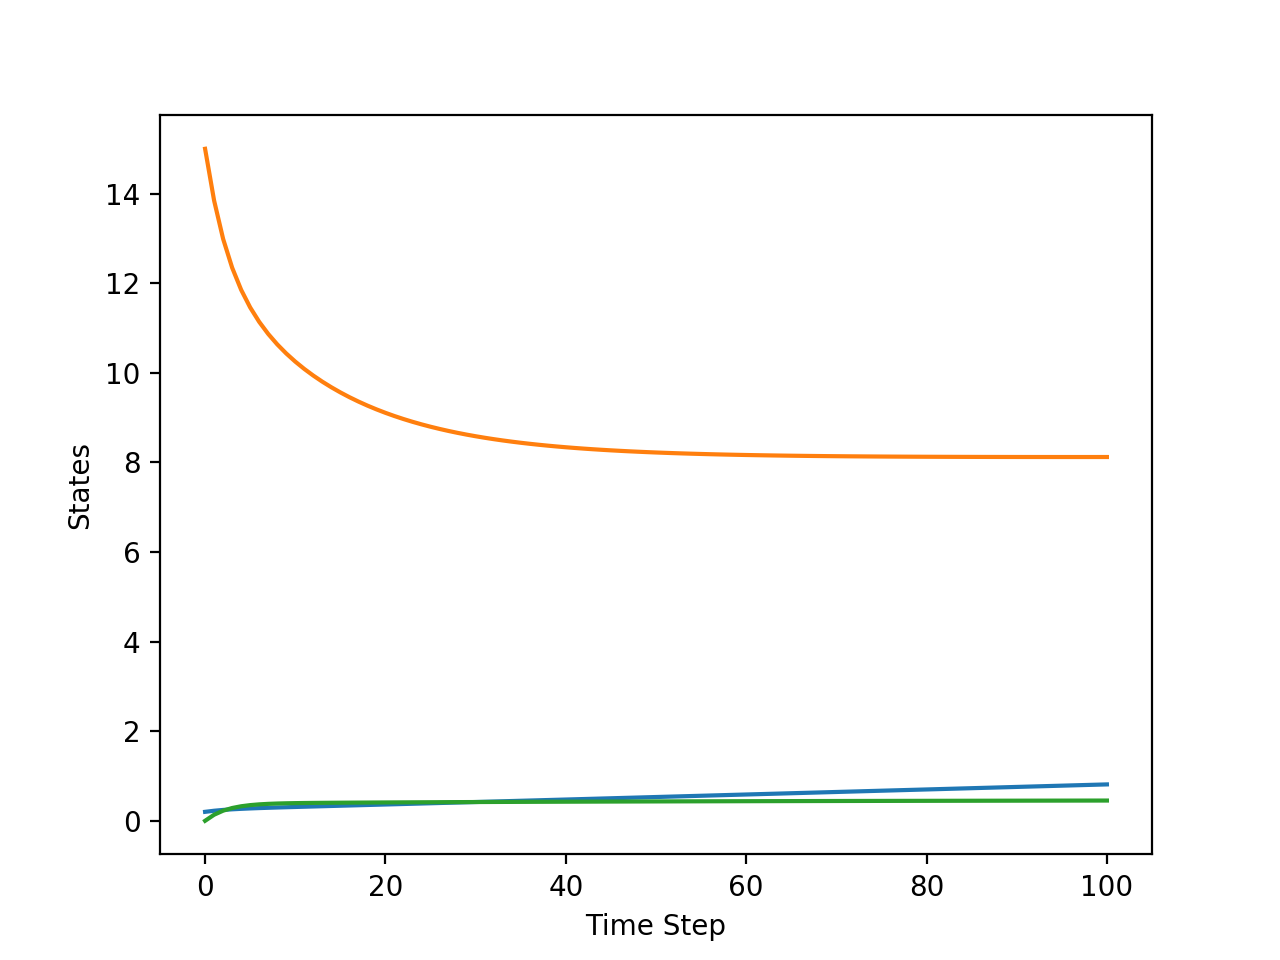

<IPython.core.display.Javascript object>


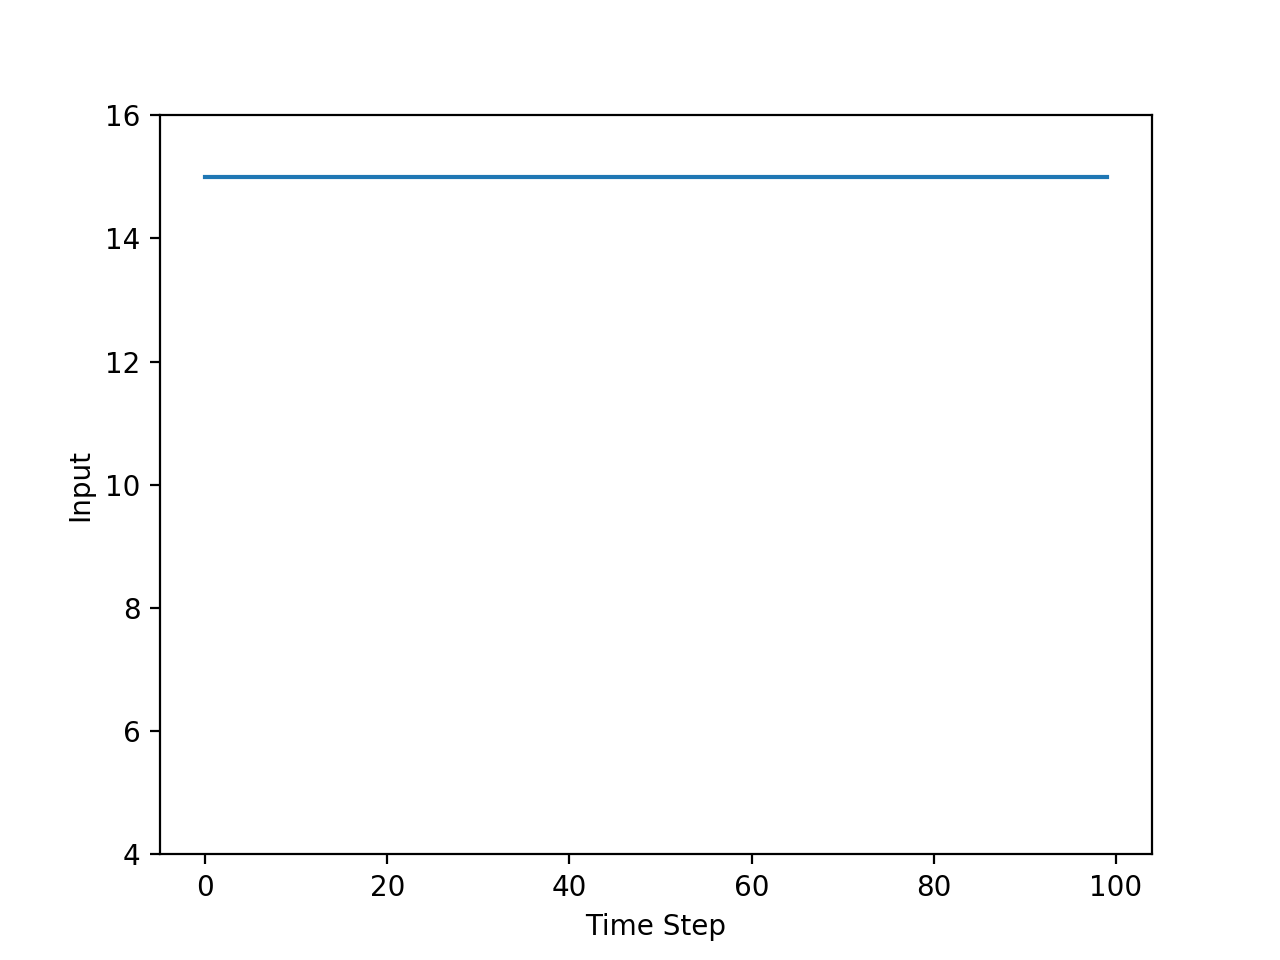

In [57]:
%matplotlib notebook
plt.figure()
plt.plot(s.xOptReal[0,:])
plt.plot(s.xOptReal[1,:])
plt.plot(s.xOptReal[2,:])
plt.xlabel('Time Step')
plt.ylabel('States')
plt.show()

plt.figure()
plt.plot(s.uOptReal[0,:])
plt.xlabel('Time Step')
plt.ylabel('Input')
plt.ylim([4, 16])
plt.show()